In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

In [4]:
def compute_nb_errors(model, data_input, data_target, batch_size):
    nb_errors = 0
    Ndata = len(data_input[:, 0, 0, 0])
    model.eval()
    print('data_target', data_target.shape)
    print('data_input', data_input.shape)
    
    for b_start in range(0, Ndata, batch_size):
        bsize_eff = batch_size - max(0, b_start+batch_size-Ndata)  # boundary case
        batch_output = model.forward(data_input.narrow(0, b_start, bsize_eff))  # is Variable if data_input is Variable
        if len(list(batch_output.size()))>1 and batch_output.size(1) > 1:
            # as many ouputs as there are classes => select maximum output
            nb_err_batch = (batch_output.max(1)[1] != data_target.narrow(0, b_start, bsize_eff)).long().sum()
            # overflow problem if conversion to Long Int not performed, treated as short 1-byte int otherwise!!
        else:
            # output is a scalar in [0, 1]
            nb_err_batch = batch_output.round().sub(data_target.narrow(0, b_start, bsize_eff)).sign().abs().sum()
        
        nb_errors += nb_err_batch
    if isinstance(nb_errors, Variable):
        nb_errors = nb_errors.data[0]
    return nb_errors

# Preprocessing and Data Augmentation

In [5]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='125Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='125Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (2400, 28, 62)
test (800, 28, 62)
validation (128, 28, 62)
Ntrain =  2400
Ntest =  800
Nvalidation =  128


# Network training and testing
Non-linearity: elu  


|criterion | optimizer | lr  | momentum | batch size | Nepochs | Train acc. | Test acc.|
|----------|-----------|-----|----------|------------|---------|------------|----------|
| BCE  | Adam  |1e-1 | def. | 15 | 150 | 86.4 | 61.4 | 
| BCE  | Adam  |1e-1 | def. | 20 | 150 | 99.8 | 79.5 | 
| BCE  | SGD   | 1e-2 | 0.85 | 20 | 150 | 98.9  | 61.5 | 
| CE   | Adam  | 1e-2 | def. | 20 | 150 | 98.4  |  70.5 | 
| CE   | SGD   | 1e-2 | 0.85 | 20 | 150 | 99.1 | 75.1 |


Non-linearity: ReLU

In [6]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 15
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 75
seeds = list(range(50))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):
    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    model = conv2DNet_3(Noutputs) #from PdM
    
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    #optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output, train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  0
	 Training accuracy:  78.5
	 Validation accuracy  60.15625
	 Test accuracy  62.5
	 Epoch Loss  99.61796569824219
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  1
	 Training accuracy:  84.91666666666667
	 Validation accuracy  77.34375
	 Test accuracy  70.875
	 Epoch Loss  65.59486389160156
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  2
	 Training accuracy:  90.66666666666667
	 Validation acc

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  23
	 Training accuracy:  99.75
	 Validation accuracy  68.75
	 Test accuracy  69.75
	 Epoch Loss  0.0535062812268734
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  24
	 Training accuracy:  99.75
	 Validation accuracy  68.75
	 Test accuracy  69.75
	 Epoch Loss  0.036846015602350235
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  25
	 Training accuracy:  99.79166666666667
	 Validation accuracy  68.75
	 Test accuracy  69.375
	 Epoch Loss  0.031112948432564735
data_target torch.Size(

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  46
	 Training accuracy:  99.83333333333333
	 Validation accuracy  68.75
	 Test accuracy  69.75
	 Epoch Loss  0.012240923941135406
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  47
	 Training accuracy:  99.83333333333333
	 Validation accuracy  68.75
	 Test accuracy  69.75
	 Epoch Loss  0.01135180238634348
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  48
	 Training accuracy:  99.83333333333333
	 Validation accuracy  68.75
	 Test accuracy  70.0
	 Epoch Loss  0.010455486364662647


Epoch Number :  69
	 Training accuracy:  99.875
	 Validation accuracy  67.96875
	 Test accuracy  69.75
	 Epoch Loss  0.0005747065297327936
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  70
	 Training accuracy:  99.875
	 Validation accuracy  67.96875
	 Test accuracy  69.75
	 Epoch Loss  0.00048152374802157283
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  71
	 Training accuracy:  99.875
	 Validation accuracy  67.96875
	 Test accuracy  69.625
	 Epoch Loss  0.00040421338053420186
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target to

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  18
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  70.875
	 Epoch Loss  0.0706840455532074
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  19
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  70.875
	 Epoch Loss  0.05654200538992882
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  20
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  71.125
	 Epoch Loss  0.045526355504989624
data_target torch.Size([2400

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  42
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  71.5
	 Epoch Loss  0.0006231475272215903
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  43
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  71.5
	 Epoch Loss  0.0005172248347662389
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  44
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  

Epoch Number :  65
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  71.25
	 Epoch Loss  9.801332453207579e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  66
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  71.25
	 Epoch Loss  8.16851661511464e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  67
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  71.25
	 Epoch Loss  6.673163170489715e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  14
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  75.125
	 Epoch Loss  0.22200651466846466
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  15
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  74.875
	 Epoch Loss  0.17069914937019348
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  16
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  74.625
	 Epoch Loss  0.13226379454135895
data_target torch.Size([2400])
dat

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  38
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  74.75
	 Epoch Loss  0.0014028351288288832
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  39
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  74.75
	 Epoch Loss  0.0011608541244640946
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  40
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  7

Epoch Number :  61
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  74.25
	 Epoch Loss  2.1379357349360362e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  62
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  73.75
	 Epoch Loss  1.7606367691769265e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  63
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  74.125
	 Epoch Loss  1.4741413906449452e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torc

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  10
	 Training accuracy:  99.79166666666667
	 Validation accuracy  89.84375
	 Test accuracy  73.875
	 Epoch Loss  0.9695058465003967
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  11
	 Training accuracy:  99.83333333333333
	 Validation accuracy  89.0625
	 Test accuracy  73.75
	 Epoch Loss  0.7860011458396912
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  12
	 Training accuracy:  99.875
	 Validation accuracy 

Epoch Number :  33
	 Training accuracy:  100.0
	 Validation accuracy  89.0625
	 Test accuracy  72.375
	 Epoch Loss  0.27875617146492004
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  34
	 Training accuracy:  100.0
	 Validation accuracy  89.0625
	 Test accuracy  72.875
	 Epoch Loss  0.2743646800518036
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  35
	 Training accuracy:  100.0
	 Validation accuracy  89.0625
	 Test accuracy  72.0
	 Epoch Loss  0.2696278393268585
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])


data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  57
	 Training accuracy:  99.875
	 Validation accuracy  91.40625
	 Test accuracy  70.625
	 Epoch Loss  0.775551974773407
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  58
	 Training accuracy:  99.91666666666667
	 Validation accuracy  91.40625
	 Test accuracy  71.0
	 Epoch Loss  0.20514589548110962
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  59
	 Training accuracy:  99.91666666666667
	 Validation accuracy  90.625
	 Test accuracy  71.25
	 Epoch Loss  0.2004602998495102
data_tar

Epoch Number :  5
	 Training accuracy:  99.75
	 Validation accuracy  81.25
	 Test accuracy  72.0
	 Epoch Loss  5.476559638977051
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  6
	 Training accuracy:  99.875
	 Validation accuracy  82.03125
	 Test accuracy  73.0
	 Epoch Loss  3.0484845638275146
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  7
	 Training accuracy:  99.875
	 Validation accuracy  81.25
	 Test accuracy  73.125
	 Epoch Loss  1.809649109840393
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_inpu

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  29
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  74.625
	 Epoch Loss  0.005506389774382114
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  30
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  74.75
	 Epoch Loss  0.0045308745466172695
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  31
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  7

Epoch Number :  52
	 Training accuracy:  100.0
	 Validation accuracy  80.46875
	 Test accuracy  74.375
	 Epoch Loss  7.56146982894279e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  53
	 Training accuracy:  100.0
	 Validation accuracy  80.46875
	 Test accuracy  74.125
	 Epoch Loss  6.324738205876201e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  54
	 Training accuracy:  100.0
	 Validation accuracy  80.46875
	 Test accuracy  74.125
	 Epoch Loss  5.2698858780786395e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  1
	 Training accuracy:  88.66666666666667
	 Validation accuracy  65.625
	 Test accuracy  71.75
	 Epoch Loss  54.48520278930664
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  2
	 Training accuracy:  87.75
	 Validation accuracy  77.34375
	 Test accuracy  67.125
	 Epoch Loss  36.693973541259766
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  3
	 Training accuracy:  95.95833333333333
	 Validation accuracy  76.56

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  24
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  74.75
	 Epoch Loss  0.024149838835000992
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  25
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  74.375
	 Epoch Loss  0.019594520330429077
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  26
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  74.375
	 Epoch Loss  0.016006456688046455
data_target torch.Size(

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  48
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  73.875
	 Epoch Loss  0.00024111775564961135
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  49
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  73.625
	 Epoch Loss  0.00020230907830409706
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  50
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test ac

Epoch Number :  71
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  73.375
	 Epoch Loss  3.922446921933442e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  72
	 Training accuracy:  100.0
	 Validation accuracy  78.90625
	 Test accuracy  73.125
	 Epoch Loss  3.141885599688976e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  73
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  73.5
	 Epoch Loss  2.543739128668676e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  20
	 Training accuracy:  100.0
	 Validation accuracy  83.59375
	 Test accuracy  70.75
	 Epoch Loss  0.05318604037165642
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  21
	 Training accuracy:  100.0
	 Validation accuracy  83.59375
	 Test accuracy  70.875
	 Epoch Loss  0.04306896775960922
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  22
	 Training accuracy:  100.0
	 Validation accuracy  84.375
	 Test accuracy  71.0
	 Epoch Loss  0.03494482487440109
data_target torch.Size([2400])

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  44
	 Training accuracy:  100.0
	 Validation accuracy  82.8125
	 Test accuracy  71.75
	 Epoch Loss  0.0004985072300769389
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  45
	 Training accuracy:  100.0
	 Validation accuracy  82.03125
	 Test accuracy  71.875
	 Epoch Loss  0.0004104810650460422
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  46
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accur

Epoch Number :  67
	 Training accuracy:  100.0
	 Validation accuracy  82.03125
	 Test accuracy  72.625
	 Epoch Loss  9.381144081999082e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  68
	 Training accuracy:  100.0
	 Validation accuracy  78.90625
	 Test accuracy  71.75
	 Epoch Loss  7.0281221269397065e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  69
	 Training accuracy:  99.58333333333333
	 Validation accuracy  79.6875
	 Test accuracy  68.875
	 Epoch Loss  0.6005001664161682
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_targ

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  16
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  72.0
	 Epoch Loss  0.08079565316438675
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  17
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  72.375
	 Epoch Loss  0.06382079422473907
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  18
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy

Epoch Number :  39
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  74.875
	 Epoch Loss  0.0007861902704462409
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  40
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  74.75
	 Epoch Loss  0.0006539009627886117
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  41
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  74.875
	 Epoch Loss  0.0005439692758955061
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Si

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  63
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  76.625
	 Epoch Loss  1.0125385415449273e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  64
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  76.75
	 Epoch Loss  8.507206985086668e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  65
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  76.75
	 Epoch Loss  7.076745532685891e-06
data_target torch.Size(

Epoch Number :  11
	 Training accuracy:  100.0
	 Validation accuracy  78.90625
	 Test accuracy  71.125
	 Epoch Loss  0.33831021189689636
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  12
	 Training accuracy:  100.0
	 Validation accuracy  78.90625
	 Test accuracy  71.25
	 Epoch Loss  0.251554936170578
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  13
	 Training accuracy:  100.0
	 Validation accuracy  78.90625
	 Test accuracy  71.0
	 Epoch Loss  0.18977287411689758
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800]

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  35
	 Training accuracy:  100.0
	 Validation accuracy  79.6875
	 Test accuracy  72.5
	 Epoch Loss  0.0017476414795964956
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  36
	 Training accuracy:  100.0
	 Validation accuracy  79.6875
	 Test accuracy  72.25
	 Epoch Loss  0.0014475942589342594
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  37
	 Training accuracy:  100.0
	 Validation accuracy  79.6875
	 Test accuracy  72.25
	 Epoch Loss  0.0011972712818533182
data_target torch.Size([24

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  59
	 Training accuracy:  100.0
	 Validation accuracy  79.6875
	 Test accuracy  73.25
	 Epoch Loss  2.177825808757916e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  60
	 Training accuracy:  100.0
	 Validation accuracy  79.6875
	 Test accuracy  73.375
	 Epoch Loss  1.813444214349147e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  61
	 Training accuracy:  100.0
	 Validation accuracy  79.6875
	 Test accu

Epoch Number :  7
	 Training accuracy:  99.70833333333333
	 Validation accuracy  76.5625
	 Test accuracy  72.75
	 Epoch Loss  1.0107924938201904
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  8
	 Training accuracy:  99.70833333333333
	 Validation accuracy  76.5625
	 Test accuracy  72.75
	 Epoch Loss  0.6808552742004395
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  9
	 Training accuracy:  99.75
	 Validation accuracy  76.5625
	 Test accuracy  72.875
	 Epoch Loss  0.47873443365097046
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_targ

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  31
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  73.75
	 Epoch Loss  0.003286331193521619
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  32
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  73.75
	 Epoch Loss  0.002715811599045992
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  33
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  

Epoch Number :  54
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  74.125
	 Epoch Loss  4.766989150084555e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  55
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  74.0
	 Epoch Loss  3.9792914321878925e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  56
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  74.125
	 Epoch Loss  3.3203905331902206e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size(

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  3
	 Training accuracy:  98.66666666666667
	 Validation accuracy  81.25
	 Test accuracy  76.125
	 Epoch Loss  17.66513442993164
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  4
	 Training accuracy:  99.5
	 Validation accuracy  80.46875
	 Test accuracy  76.0
	 Epoch Loss  9.084866523742676
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  5
	 Training accuracy:  99.83333333333333
	 Validation accuracy  78.90625
	 Test accuracy  75.5
	 Epoch Loss  4.916415214538574
data_target torch.

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  27
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  76.25
	 Epoch Loss  0.009042582474648952
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  28
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  76.25
	 Epoch Loss  0.007412091363221407
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  29
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  76.

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  51
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  76.625
	 Epoch Loss  9.959864109987393e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  52
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  76.75
	 Epoch Loss  8.401704690186307e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  53
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  

Epoch Number :  74
	 Training accuracy:  99.83333333333333
	 Validation accuracy  79.6875
	 Test accuracy  77.375
	 Epoch Loss  0.0007235627854242921
Repetition 11
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  0
	 Training accuracy:  79.58333333333333
	 Validation accuracy  59.375
	 Test accuracy  57.875
	 Epoch Loss  99.10032653808594
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  1
	 Training accuracy:  90.95833333333333
	 Validation accuracy  65.625
	 Test accuracy  61.5
	 Epoch Loss  63.274173736572266
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  23
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  68.5
	 Epoch Loss  0.017509592697024345
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  24
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  68.625
	 Epoch Loss  0.014232589863240719
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  25
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  68.75
	 Epoch Loss  0.011687994003295898
data_target torch.Size([2400])
dat

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  47
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  69.5
	 Epoch Loss  0.00018187247042078525
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  48
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  69.5
	 Epoch Loss  0.0001517266791779548
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  49
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test acc

Epoch Number :  70
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  70.125
	 Epoch Loss  2.9152381557651097e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  71
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  70.125
	 Epoch Loss  2.3956513359735254e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  72
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  70.125
	 Epoch Loss  2.0107211184949847e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target to

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  19
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  69.375
	 Epoch Loss  0.041744161397218704
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  20
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  69.5
	 Epoch Loss  0.03357861191034317
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  21
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accur

Epoch Number :  42
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  70.625
	 Epoch Loss  0.0004606495494954288
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  43
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  70.625
	 Epoch Loss  0.0003829812922049314
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  44
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  70.75
	 Epoch Loss  0.00031804043101146817
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.S

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  66
	 Training accuracy:  100.0
	 Validation accuracy  72.65625
	 Test accuracy  71.875
	 Epoch Loss  6.0697293520206586e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  67
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  72.0
	 Epoch Loss  4.9093969209934585e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  68
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  71.5
	 Epoch Loss  4.42433474745485e-06
data_target torch.Size([2

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  15
	 Training accuracy:  100.0
	 Validation accuracy  75.78125
	 Test accuracy  73.0
	 Epoch Loss  0.10684706270694733
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  16
	 Training accuracy:  100.0
	 Validation accuracy  75.78125
	 Test accuracy  73.25
	 Epoch Loss  0.0838330090045929
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  17
	 Training accuracy:  100.0
	 Validation accuracy  75.78125
	 Test accuracy

Epoch Number :  38
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  73.875
	 Epoch Loss  0.0009681737283244729
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  39
	 Training accuracy:  100.0
	 Validation accuracy  78.90625
	 Test accuracy  73.875
	 Epoch Loss  0.0008037157240323722
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  40
	 Training accuracy:  100.0
	 Validation accuracy  78.90625
	 Test accuracy  74.25
	 Epoch Loss  0.0006653741584159434
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Si

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  62
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  75.25
	 Epoch Loss  1.2701002560788766e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  63
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  75.25
	 Epoch Loss  1.0421720617159735e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  64
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  75.375
	 Epoch Loss  8.73262069944758e-06
data_target torch.Size([2400]

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  11
	 Training accuracy:  99.95833333333333
	 Validation accuracy  78.125
	 Test accuracy  71.875
	 Epoch Loss  0.40859392285346985
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  12
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  71.875
	 Epoch Loss  0.2984176576137543
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  13
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 

Epoch Number :  34
	 Training accuracy:  100.0
	 Validation accuracy  75.0
	 Test accuracy  73.375
	 Epoch Loss  0.0023561972193419933
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  35
	 Training accuracy:  100.0
	 Validation accuracy  75.0
	 Test accuracy  73.375
	 Epoch Loss  0.0019318859558552504
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  36
	 Training accuracy:  100.0
	 Validation accuracy  75.0
	 Test accuracy  73.375
	 Epoch Loss  0.0016013546846807003
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  58
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  74.875
	 Epoch Loss  2.89132021862315e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  59
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  74.875
	 Epoch Loss  2.4107697754516266e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  60
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  75.0
	 Epoch Loss  1.9838671505567618e-05
data_target torch.Size(

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  7
	 Training accuracy:  100.0
	 Validation accuracy  72.65625
	 Test accuracy  70.375
	 Epoch Loss  1.537390112876892
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  8
	 Training accuracy:  100.0
	 Validation accuracy  72.65625
	 Test accuracy  70.375
	 Epoch Loss  1.030326008796692
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  9
	 Training accuracy:  100.0
	 Validation accuracy  72.65625
	 Test accuracy  7

Epoch Number :  30
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  72.25
	 Epoch Loss  0.0054635643027722836
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  31
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  72.25
	 Epoch Loss  0.0045084645971655846
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  32
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  72.125
	 Epoch Loss  0.0037184562534093857
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([8

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  54
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  72.25
	 Epoch Loss  6.438633863581344e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  55
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  72.25
	 Epoch Loss  5.399368819780648e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  56
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  72.375
	 Epoch Loss  4.4970191083848476e-05
data_target torch.Size([24

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  3
	 Training accuracy:  97.33333333333333
	 Validation accuracy  64.84375
	 Test accuracy  73.75
	 Epoch Loss  26.858652114868164
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  4
	 Training accuracy:  95.58333333333333
	 Validation accuracy  62.5
	 Test accuracy  69.5
	 Epoch Loss  14.118911743164062
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  5
	 Training accuracy:  99.54166666666667
	 Validation accura

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  26
	 Training accuracy:  99.95833333333333
	 Validation accuracy  68.75
	 Test accuracy  77.375
	 Epoch Loss  0.015191425569355488
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  27
	 Training accuracy:  99.95833333333333
	 Validation accuracy  68.75
	 Test accuracy  77.375
	 Epoch Loss  0.01239931769669056
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  28
	 Training accuracy:  99.95833333333333
	 Validation accuracy  68.75
	 Test accuracy  77.375
	 Epoch Loss  0.010150340385735

Epoch Number :  49
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  78.625
	 Epoch Loss  0.0001934222091222182
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  50
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  78.625
	 Epoch Loss  0.00016264934674836695
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  51
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  78.75
	 Epoch Loss  0.00013601280807051808
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([8

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  73
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  78.625
	 Epoch Loss  2.5781087060749996e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  74
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  78.875
	 Epoch Loss  2.224401669081999e-06
Repetition 17
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  0
	 Training accuracy:  82.25
	 Validation accuracy  71.09375
	 Test accuracy  69.125
	 Epoch Loss  92.79634094238281
data_target tor

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  21
	 Training accuracy:  99.91666666666667
	 Validation accuracy  76.5625
	 Test accuracy  76.375
	 Epoch Loss  0.037133798003196716
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  22
	 Training accuracy:  99.91666666666667
	 Validation accuracy  76.5625
	 Test accuracy  76.125
	 Epoch Loss  0.03020307421684265
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  23
	 Training accuracy:  99.91666666666667
	 Validation accuracy  75.78125
	 Test accuracy  76.25
	 Epoch Loss  0.024436643

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  44
	 Training accuracy:  99.95833333333333
	 Validation accuracy  75.0
	 Test accuracy  76.625
	 Epoch Loss  0.00043645690311677754
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  45
	 Training accuracy:  99.95833333333333
	 Validation accuracy  75.0
	 Test accuracy  76.625
	 Epoch Loss  0.0003625295648816973
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  46
	 Training accuracy:  99.95833333333333
	 Validation accuracy  75.0
	 Test accuracy  76.625
	 Epoch Loss  0.00030235233134

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  67
	 Training accuracy:  99.95833333333333
	 Validation accuracy  75.0
	 Test accuracy  77.125
	 Epoch Loss  7.0459377639053855e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  68
	 Training accuracy:  99.95833333333333
	 Validation accuracy  74.21875
	 Test accuracy  77.125
	 Epoch Loss  5.742059329350013e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  69
	 Training accuracy:  99.95833333333333
	 Vali

Epoch Number :  15
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  68.625
	 Epoch Loss  0.0922701358795166
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  16
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  68.625
	 Epoch Loss  0.07282082736492157
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  17
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  68.625
	 Epoch Loss  0.057680126279592514
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
da

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  39
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  69.125
	 Epoch Loss  0.0007258841651491821
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  40
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  69.125
	 Epoch Loss  0.0006042254972271621
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  41
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  69.375
	 Epoch Loss  0.0005011938628740609
data_target torch.Siz

Epoch Number :  62
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  69.875
	 Epoch Loss  1.1384001481928863e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  63
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  69.875
	 Epoch Loss  9.61749265115941e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  64
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  69.875
	 Epoch Loss  7.99749614088796e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Si

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  11
	 Training accuracy:  100.0
	 Validation accuracy  82.03125
	 Test accuracy  76.25
	 Epoch Loss  0.4004395306110382
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  12
	 Training accuracy:  100.0
	 Validation accuracy  84.375
	 Test accuracy  76.25
	 Epoch Loss  0.2960392236709595
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  13
	 Training accuracy:  100.0
	 Validation accuracy  84.375
	 Test accuracy  75

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  35
	 Training accuracy:  100.0
	 Validation accuracy  84.375
	 Test accuracy  74.25
	 Epoch Loss  0.0020368131808936596
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  36
	 Training accuracy:  100.0
	 Validation accuracy  84.375
	 Test accuracy  74.375
	 Epoch Loss  0.001681086840108037
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  37
	 Training accuracy:  100.0
	 Validation accuracy  83.59375
	 Test accura

Epoch Number :  58
	 Training accuracy:  100.0
	 Validation accuracy  83.59375
	 Test accuracy  74.25
	 Epoch Loss  0.009706366807222366
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  59
	 Training accuracy:  100.0
	 Validation accuracy  82.8125
	 Test accuracy  74.125
	 Epoch Loss  0.007321454118937254
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  60
	 Training accuracy:  100.0
	 Validation accuracy  82.8125
	 Test accuracy  74.25
	 Epoch Loss  0.005731354467570782
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  7
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  78.25
	 Epoch Loss  1.6524184942245483
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  8
	 Training accuracy:  100.0
	 Validation accuracy  72.65625
	 Test accuracy  78.375
	 Epoch Loss  1.0609349012374878
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  9
	 Training accuracy:  100.0
	 Validation accuracy  72.65625
	 Test accuracy  7

Epoch Number :  30
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  78.75
	 Epoch Loss  0.004996356554329395
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  31
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  78.875
	 Epoch Loss  0.0040937913581728935
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  32
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  79.0
	 Epoch Loss  0.0033961357548832893
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  54
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  78.75
	 Epoch Loss  5.889882959309034e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  55
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  78.75
	 Epoch Loss  4.9225145630771294e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  56
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  78.75
	 Epoch Loss  4.1171293560182676e-05
data_target torch.Size([24

Epoch Number :  2
	 Training accuracy:  97.58333333333333
	 Validation accuracy  72.65625
	 Test accuracy  69.625
	 Epoch Loss  26.2457218170166
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  3
	 Training accuracy:  98.375
	 Validation accuracy  74.21875
	 Test accuracy  68.875
	 Epoch Loss  13.583070755004883
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  4
	 Training accuracy:  99.58333333333333
	 Validation accuracy  73.4375
	 Test accuracy  68.625
	 Epoch Loss  7.5716376304626465
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_ta

Epoch Number :  26
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  67.75
	 Epoch Loss  0.012154445052146912
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  27
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  67.625
	 Epoch Loss  0.009969644248485565
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  28
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  67.5
	 Epoch Loss  0.008203896693885326
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  50
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accuracy  68.125
	 Epoch Loss  0.0001333065883954987
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  51
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accuracy  68.0
	 Epoch Loss  0.00011191565863555297
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  52
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accuracy  68.125
	 Epoch Loss  9.292484173784032e-05
data_target torch.Size(

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  74
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accuracy  68.375
	 Epoch Loss  1.7612043166082003e-06
Repetition 22
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  0
	 Training accuracy:  73.75
	 Validation accuracy  59.375
	 Test accuracy  56.75
	 Epoch Loss  104.66671752929688
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  1
	 Training accuracy:  87.75
	 Validation accuracy  66.40625
	

Epoch Number :  22
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accuracy  74.5
	 Epoch Loss  0.03602118417620659
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  23
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accuracy  74.25
	 Epoch Loss  0.029143059626221657
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  24
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accuracy  74.5
	 Epoch Loss  0.023675020784139633
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  46
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  75.375
	 Epoch Loss  0.0003432577068451792
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  47
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  75.75
	 Epoch Loss  0.00028598299832083285
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  48
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  75.75
	 Epoch Loss  0.00023940193932503462
data_target torch.S

Epoch Number :  69
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  76.625
	 Epoch Loss  5.2884242904838175e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  70
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  76.875
	 Epoch Loss  4.307466042519081e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  71
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  76.75
	 Epoch Loss  3.7676593365176814e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.S

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  18
	 Training accuracy:  100.0
	 Validation accuracy  64.84375
	 Test accuracy  66.0
	 Epoch Loss  0.0506712980568409
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  19
	 Training accuracy:  100.0
	 Validation accuracy  64.84375
	 Test accuracy  66.25
	 Epoch Loss  0.04051956906914711
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  20
	 Training accuracy:  100.0
	 Validation accuracy  64.0625
	 Test accuracy 

Epoch Number :  41
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  67.5
	 Epoch Loss  0.0005350149003788829
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  42
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  67.625
	 Epoch Loss  0.00044623835128732026
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  43
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  67.75
	 Epoch Loss  0.0003717434883583337
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.S

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  65
	 Training accuracy:  100.0
	 Validation accuracy  65.625
	 Test accuracy  69.0
	 Epoch Loss  6.939926606719382e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  66
	 Training accuracy:  100.0
	 Validation accuracy  64.0625
	 Test accuracy  68.5
	 Epoch Loss  5.784600489278091e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  67
	 Training accuracy:  100.0
	 Validation accuracy  65.625
	 Test accuracy  68.375
	 Epoch Loss  4.873103989666561e-06
data_target torch.Size([2400

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  14
	 Training accuracy:  100.0
	 Validation accuracy  57.03125
	 Test accuracy  73.25
	 Epoch Loss  0.13760705292224884
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  15
	 Training accuracy:  100.0
	 Validation accuracy  57.03125
	 Test accuracy  73.25
	 Epoch Loss  0.10629164427518845
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  16
	 Training accuracy:  100.0
	 Validation accuracy  57.8125
	 Test accurac

Epoch Number :  37
	 Training accuracy:  100.0
	 Validation accuracy  58.59375
	 Test accuracy  74.125
	 Epoch Loss  0.001159628969617188
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  38
	 Training accuracy:  100.0
	 Validation accuracy  59.375
	 Test accuracy  74.0
	 Epoch Loss  0.0009595587034709752
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  39
	 Training accuracy:  100.0
	 Validation accuracy  59.375
	 Test accuracy  74.25
	 Epoch Loss  0.0008043959969654679
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([8

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  61
	 Training accuracy:  100.0
	 Validation accuracy  59.375
	 Test accuracy  74.625
	 Epoch Loss  1.4689011550217401e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  62
	 Training accuracy:  100.0
	 Validation accuracy  58.59375
	 Test accuracy  74.625
	 Epoch Loss  1.2400810192048084e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  63
	 Training accuracy:  100.0
	 Validation accuracy  59.375
	 Test accuracy  74.625
	 Epoch Loss  1.0155958989344072e-05
data_target torch.Si

Epoch Number :  9
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  71.625
	 Epoch Loss  0.690274715423584
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  10
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  71.75
	 Epoch Loss  0.4795874357223511
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  11
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  71.25
	 Epoch Loss  0.34429991245269775
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])


data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  33
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  72.0
	 Epoch Loss  0.0025528082624077797
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  34
	 Training accuracy:  100.0
	 Validation accuracy  74.21875
	 Test accuracy  72.0
	 Epoch Loss  0.0021065757609903812
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  35
	 Training accuracy:  100.0
	 Validation accuracy  74.21875
	 Test accuracy  72.125
	 Epoch Loss  0.001734779099933803
data_target torch.Size([2

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  57
	 Training accuracy:  100.0
	 Validation accuracy  75.0
	 Test accuracy  72.25
	 Epoch Loss  3.024681245733518e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  58
	 Training accuracy:  100.0
	 Validation accuracy  75.0
	 Test accuracy  72.25
	 Epoch Loss  2.557118386903312e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  59
	 Training accuracy:  100.0
	 Validation accuracy  75.0
	 Test accuracy  72.2

Epoch Number :  5
	 Training accuracy:  99.20833333333333
	 Validation accuracy  78.90625
	 Test accuracy  66.25
	 Epoch Loss  5.179439067840576
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  6
	 Training accuracy:  99.58333333333333
	 Validation accuracy  77.34375
	 Test accuracy  67.5
	 Epoch Loss  2.675144672393799
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  7
	 Training accuracy:  99.875
	 Validation accuracy  76.5625
	 Test accuracy  67.75
	 Epoch Loss  1.5932443141937256
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  29
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  73.75
	 Epoch Loss  0.005434390623122454
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  30
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  73.875
	 Epoch Loss  0.004487138241529465
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  31
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accura

Epoch Number :  52
	 Training accuracy:  100.0
	 Validation accuracy  75.78125
	 Test accuracy  75.0
	 Epoch Loss  7.65241784392856e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  53
	 Training accuracy:  100.0
	 Validation accuracy  75.78125
	 Test accuracy  75.125
	 Epoch Loss  6.280138768488541e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  54
	 Training accuracy:  100.0
	 Validation accuracy  75.78125
	 Test accuracy  75.625
	 Epoch Loss  5.151097502675839e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Si

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  1
	 Training accuracy:  89.54166666666667
	 Validation accuracy  61.71875
	 Test accuracy  75.875
	 Epoch Loss  63.81715393066406
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  2
	 Training accuracy:  96.29166666666667
	 Validation accuracy  71.09375
	 Test accuracy  73.75
	 Epoch Loss  38.82405471801758
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  3
	 Training accuracy:  98.58333333333333
	 Validation accuracy  71.09375
	 Test accuracy  74.125
	 Epoch Loss  20.03378868103027

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  25
	 Training accuracy:  100.0
	 Validation accuracy  74.21875
	 Test accuracy  73.5
	 Epoch Loss  0.01564900018274784
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  26
	 Training accuracy:  100.0
	 Validation accuracy  74.21875
	 Test accuracy  73.375
	 Epoch Loss  0.012784638442099094
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  27
	 Training accuracy:  100.0
	 Validation accuracy  74.21875
	 Test accur

Epoch Number :  48
	 Training accuracy:  100.0
	 Validation accuracy  74.21875
	 Test accuracy  73.0
	 Epoch Loss  0.00020137698447797447
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  49
	 Training accuracy:  100.0
	 Validation accuracy  74.21875
	 Test accuracy  73.0
	 Epoch Loss  0.00016636114742141217
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  50
	 Training accuracy:  100.0
	 Validation accuracy  74.21875
	 Test accuracy  73.0
	 Epoch Loss  0.00013873189163859934
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Si

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  72
	 Training accuracy:  100.0
	 Validation accuracy  75.0
	 Test accuracy  73.25
	 Epoch Loss  0.0004549597215373069
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  73
	 Training accuracy:  100.0
	 Validation accuracy  75.0
	 Test accuracy  73.375
	 Epoch Loss  0.00039474567165598273
Epoch    74: reducing learning rate of group 0 to 2.0000e-04.
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  74
	 Training accuracy:  100.0
	 Validation accuracy  75.0
	 Test accuracy  73.375
	 Epo

Epoch Number :  20
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  73.5
	 Epoch Loss  0.06104263290762901
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  21
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  73.25
	 Epoch Loss  0.049386851489543915
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  22
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  73.375
	 Epoch Loss  0.03952786326408386
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
d

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  44
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  72.875
	 Epoch Loss  0.0005405090050771832
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  45
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  72.75
	 Epoch Loss  0.0004492179723456502
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  46
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  73.0
	 Epoch Loss  0.00037411224911920726
data_target torch.Siz

Epoch Number :  67
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  72.75
	 Epoch Loss  8.360377250937745e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  68
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  72.75
	 Epoch Loss  7.055048172333045e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  69
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  72.75
	 Epoch Loss  5.894540208828403e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size(

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  16
	 Training accuracy:  100.0
	 Validation accuracy  79.6875
	 Test accuracy  73.5
	 Epoch Loss  0.08410833775997162
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  17
	 Training accuracy:  100.0
	 Validation accuracy  79.6875
	 Test accuracy  73.5
	 Epoch Loss  0.06641949713230133
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  18
	 Training accuracy:  100.0
	 Validation accuracy  79.6875
	 Test accuracy  73.75
	 Epoch Loss  0.05277814343571663
data_target torch.Size([2400])
da

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  40
	 Training accuracy:  100.0
	 Validation accuracy  82.8125
	 Test accuracy  73.75
	 Epoch Loss  0.0006757430383004248
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  41
	 Training accuracy:  100.0
	 Validation accuracy  82.8125
	 Test accuracy  73.75
	 Epoch Loss  0.000554308295249939
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  42
	 Training accuracy:  100.0
	 Validation accuracy  82.8125
	 Test accura

Epoch Number :  63
	 Training accuracy:  100.0
	 Validation accuracy  84.375
	 Test accuracy  74.5
	 Epoch Loss  1.0321762601961382e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  64
	 Training accuracy:  100.0
	 Validation accuracy  84.375
	 Test accuracy  74.5
	 Epoch Loss  8.537215762771666e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  65
	 Training accuracy:  100.0
	 Validation accuracy  83.59375
	 Test accuracy  74.75
	 Epoch Loss  7.1813055910752155e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  12
	 Training accuracy:  100.0
	 Validation accuracy  78.90625
	 Test accuracy  71.75
	 Epoch Loss  0.3990846574306488
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  13
	 Training accuracy:  100.0
	 Validation accuracy  78.90625
	 Test accuracy  71.75
	 Epoch Loss  0.3119797110557556
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  14
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  71.625
	 Epoch Loss  0.24525707960128784
data_target torch.Size([2400])


data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  36
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  71.125
	 Epoch Loss  0.0026621364522725344
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  37
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  71.125
	 Epoch Loss  0.0022016018629074097
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  38
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accura

Epoch Number :  59
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  70.5
	 Epoch Loss  3.943089905078523e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  60
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  70.625
	 Epoch Loss  3.276963616372086e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  61
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  70.625
	 Epoch Loss  2.7679949198500253e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  8
	 Training accuracy:  99.91666666666667
	 Validation accuracy  71.09375
	 Test accuracy  77.625
	 Epoch Loss  1.0417364835739136
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  9
	 Training accuracy:  99.91666666666667
	 Validation accuracy  70.3125
	 Test accuracy  77.875
	 Epoch Loss  0.7352875471115112
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  10
	 Training accuracy:  99.95833333333333
	 Validation

Epoch Number :  31
	 Training accuracy:  100.0
	 Validation accuracy  64.0625
	 Test accuracy  77.25
	 Epoch Loss  0.004807898309081793
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  32
	 Training accuracy:  100.0
	 Validation accuracy  64.0625
	 Test accuracy  77.375
	 Epoch Loss  0.003951795864850283
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  33
	 Training accuracy:  100.0
	 Validation accuracy  64.0625
	 Test accuracy  77.5
	 Epoch Loss  0.0033066708128899336
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([8

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  55
	 Training accuracy:  100.0
	 Validation accuracy  64.0625
	 Test accuracy  77.375
	 Epoch Loss  5.7517831010045484e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  56
	 Training accuracy:  100.0
	 Validation accuracy  64.0625
	 Test accuracy  77.25
	 Epoch Loss  4.810760947293602e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  57
	 Training accuracy:  100.0
	 Validation accuracy  64.0625
	 Test accuracy  77.25
	 Epoch Loss  3.970600664615631e-05
data_target torch.Size(

Epoch Number :  3
	 Training accuracy:  98.04166666666667
	 Validation accuracy  49.21875
	 Test accuracy  65.375
	 Epoch Loss  15.723518371582031
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  4
	 Training accuracy:  99.125
	 Validation accuracy  46.875
	 Test accuracy  66.375
	 Epoch Loss  7.578483581542969
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  5
	 Training accuracy:  99.875
	 Validation accuracy  49.21875
	 Test accuracy  68.375
	 Epoch Loss  3.979677200317383
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.S

Epoch Number :  26
	 Training accuracy:  99.95833333333333
	 Validation accuracy  53.90625
	 Test accuracy  72.625
	 Epoch Loss  0.009636221453547478
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  27
	 Training accuracy:  99.95833333333333
	 Validation accuracy  53.90625
	 Test accuracy  72.5
	 Epoch Loss  0.007884926162660122
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  28
	 Training accuracy:  99.95833333333333
	 Validation accuracy  53.90625
	 Test accuracy  72.625
	 Epoch Loss  0.006479286588728428
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128

Epoch Number :  49
	 Training accuracy:  99.95833333333333
	 Validation accuracy  53.90625
	 Test accuracy  73.0
	 Epoch Loss  0.00012748681183438748
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  50
	 Training accuracy:  99.95833333333333
	 Validation accuracy  53.125
	 Test accuracy  73.0
	 Epoch Loss  0.00010604417911963537
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  51
	 Training accuracy:  99.95833333333333
	 Validation accuracy  53.90625
	 Test accuracy  73.0
	 Epoch Loss  8.863044786266983e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128,

Epoch Number :  72
	 Training accuracy:  100.0
	 Validation accuracy  54.6875
	 Test accuracy  73.0
	 Epoch Loss  1.9543163034541067e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  73
	 Training accuracy:  99.91666666666667
	 Validation accuracy  54.6875
	 Test accuracy  72.625
	 Epoch Loss  1.6978110579657368e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  74
	 Training accuracy:  100.0
	 Validation accuracy  53.90625
	 Test accuracy  73.25
	 Epoch Loss  1.4893856814524042e-06
Repetition 33
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  21
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  79.125
	 Epoch Loss  0.028849883005023003
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  22
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  78.875
	 Epoch Loss  0.023411113768815994
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  23
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  79.0
	 Epoch Loss  0.019079817458987236
data_target torch.Size([2400

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  45
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  79.5
	 Epoch Loss  0.00028477859450504184
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  46
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  79.375
	 Epoch Loss  0.0002361306396778673
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  47
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test a

Epoch Number :  68
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  79.75
	 Epoch Loss  4.433343292475911e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  69
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  79.75
	 Epoch Loss  3.7074219108035322e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  70
	 Training accuracy:  100.0
	 Validation accuracy  76.5625
	 Test accuracy  79.75
	 Epoch Loss  3.19653122460295e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Siz

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  17
	 Training accuracy:  99.875
	 Validation accuracy  78.125
	 Test accuracy  65.75
	 Epoch Loss  0.06537579745054245
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  18
	 Training accuracy:  99.875
	 Validation accuracy  78.125
	 Test accuracy  65.75
	 Epoch Loss  0.05205970257520676
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  19
	 Training accuracy:  99.875
	 Validation accuracy  78.125
	 Test accuracy 

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  40
	 Training accuracy:  99.95833333333333
	 Validation accuracy  76.5625
	 Test accuracy  67.875
	 Epoch Loss  0.000675220275297761
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  41
	 Training accuracy:  99.95833333333333
	 Validation accuracy  75.78125
	 Test accuracy  67.875
	 Epoch Loss  0.0005573845119215548
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  42
	 Training accuracy:  99.95833333333333
	 Val

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  63
	 Training accuracy:  99.75
	 Validation accuracy  69.53125
	 Test accuracy  69.875
	 Epoch Loss  0.001667332835495472
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  64
	 Training accuracy:  99.75
	 Validation accuracy  69.53125
	 Test accuracy  69.75
	 Epoch Loss  0.0016235978109762073
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  65
	 Training accuracy:  99.75
	 Validation accuracy  69.53125
	 Test ac

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  11
	 Training accuracy:  100.0
	 Validation accuracy  62.5
	 Test accuracy  81.125
	 Epoch Loss  0.25575610995292664
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  12
	 Training accuracy:  100.0
	 Validation accuracy  62.5
	 Test accuracy  81.25
	 Epoch Loss  0.19302880764007568
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  13
	 Training accuracy:  100.0
	 Validation accuracy  62.5
	 Test accuracy  81.125


data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  35
	 Training accuracy:  100.0
	 Validation accuracy  62.5
	 Test accuracy  82.125
	 Epoch Loss  0.0014979320112615824
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  36
	 Training accuracy:  100.0
	 Validation accuracy  62.5
	 Test accuracy  82.25
	 Epoch Loss  0.0012440658174455166
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  37
	 Training accuracy:  100.0
	 Validation accuracy  62.5
	 Test accuracy  82.

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  59
	 Training accuracy:  100.0
	 Validation accuracy  64.84375
	 Test accuracy  81.25
	 Epoch Loss  0.0004073992313351482
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  60
	 Training accuracy:  100.0
	 Validation accuracy  64.84375
	 Test accuracy  81.25
	 Epoch Loss  0.00035464216489344835
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  61
	 Training accuracy:  100.0
	 Validation accuracy  64.0625
	 Test ac

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  7
	 Training accuracy:  99.5
	 Validation accuracy  81.25
	 Test accuracy  68.5
	 Epoch Loss  2.818234920501709
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  8
	 Training accuracy:  99.875
	 Validation accuracy  81.25
	 Test accuracy  69.0
	 Epoch Loss  2.0272178649902344
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  9
	 Training accuracy:  99.875
	 Validation accuracy  82.03125
	 Test accuracy  69.375
	 Epoch Loss  1.3585766553878784
data_target torch.Size([2400])
data_input

Epoch Number :  30
	 Training accuracy:  99.95833333333333
	 Validation accuracy  80.46875
	 Test accuracy  70.625
	 Epoch Loss  0.017222899943590164
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  31
	 Training accuracy:  99.95833333333333
	 Validation accuracy  80.46875
	 Test accuracy  70.25
	 Epoch Loss  0.014078399166464806
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  32
	 Training accuracy:  99.95833333333333
	 Validation accuracy  80.46875
	 Test accuracy  70.25
	 Epoch Loss  0.011574980802834034
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128

Epoch Number :  53
	 Training accuracy:  99.95833333333333
	 Validation accuracy  80.46875
	 Test accuracy  69.5
	 Epoch Loss  0.00023416934709530324
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  54
	 Training accuracy:  99.95833333333333
	 Validation accuracy  80.46875
	 Test accuracy  69.375
	 Epoch Loss  0.00019553382298909128
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  55
	 Training accuracy:  99.95833333333333
	 Validation accuracy  80.46875
	 Test accuracy  69.625
	 Epoch Loss  0.0001642668794374913
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  2
	 Training accuracy:  97.29166666666667
	 Validation accuracy  68.75
	 Test accuracy  70.25
	 Epoch Loss  26.137205123901367
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  3
	 Training accuracy:  98.66666666666667
	 Validation accuracy  75.78125
	 Test accuracy  71.625
	 Epoch Loss  13.171696662902832
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  4
	 Training accuracy:  99.5
	 Validation accuracy  77.343

Epoch Number :  25
	 Training accuracy:  99.79166666666667
	 Validation accuracy  80.46875
	 Test accuracy  73.875
	 Epoch Loss  0.012263326905667782
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  26
	 Training accuracy:  99.91666666666667
	 Validation accuracy  81.25
	 Test accuracy  74.0
	 Epoch Loss  0.00998278334736824
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  27
	 Training accuracy:  99.79166666666667
	 Validation accuracy  81.25
	 Test accuracy  73.875
	 Epoch Loss  0.008265471085906029
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28

Epoch Number :  48
	 Training accuracy:  99.95833333333333
	 Validation accuracy  81.25
	 Test accuracy  73.625
	 Epoch Loss  0.00016005922225303948
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  49
	 Training accuracy:  99.95833333333333
	 Validation accuracy  81.25
	 Test accuracy  73.5
	 Epoch Loss  0.00013414108252618462
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  50
	 Training accuracy:  99.95833333333333
	 Validation accuracy  81.25
	 Test accuracy  73.5
	 Epoch Loss  0.00011119132250314578
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  72
	 Training accuracy:  99.91666666666667
	 Validation accuracy  85.15625
	 Test accuracy  76.25
	 Epoch Loss  0.0009286007843911648
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  73
	 Training accuracy:  99.95833333333333
	 Validation accuracy  85.15625
	 Test accuracy  76.25
	 Epoch Loss  0.0008005697745829821
Epoch    74: reducing learning rate of group 0 to 2.0000e-04.
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Ep

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  20
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  72.375
	 Epoch Loss  0.04160056635737419
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  21
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  72.75
	 Epoch Loss  0.03340417891740799
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  22
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy

Epoch Number :  43
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  73.625
	 Epoch Loss  0.00045988999772816896
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  44
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  73.75
	 Epoch Loss  0.00037936033913865685
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  45
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  73.75
	 Epoch Loss  0.00031644178670831025
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torc

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  67
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  73.75
	 Epoch Loss  5.984117706248071e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  68
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  73.75
	 Epoch Loss  4.9377104005543515e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  69
	 Training accuracy:  100.0
	 Validation accuracy  74.21875
	 Test acc

Epoch Number :  15
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  74.5
	 Epoch Loss  0.12293415516614914
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  16
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  74.5
	 Epoch Loss  0.09602924436330795
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  17
	 Training accuracy:  100.0
	 Validation accuracy  73.4375
	 Test accuracy  74.5
	 Epoch Loss  0.07534710317850113
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
da

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  39
	 Training accuracy:  100.0
	 Validation accuracy  75.78125
	 Test accuracy  73.75
	 Epoch Loss  0.0008836634224280715
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  40
	 Training accuracy:  100.0
	 Validation accuracy  75.78125
	 Test accuracy  73.75
	 Epoch Loss  0.000734745233785361
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  41
	 Training accuracy:  100.0
	 Validation accuracy  75.78125
	 Test accuracy  73.75
	 Epoch Loss  0.0006133168935775757
data_target torch.Size(

Epoch Number :  62
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  73.625
	 Epoch Loss  1.3669052350451238e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  63
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  73.5
	 Epoch Loss  1.1438570254540537e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  64
	 Training accuracy:  100.0
	 Validation accuracy  77.34375
	 Test accuracy  73.5
	 Epoch Loss  9.53874859987991e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  11
	 Training accuracy:  99.95833333333333
	 Validation accuracy  71.09375
	 Test accuracy  73.125
	 Epoch Loss  0.6308825016021729
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  12
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  73.375
	 Epoch Loss  0.4516477584838867
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  13
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Tes

Epoch Number :  34
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  74.75
	 Epoch Loss  0.003166487207636237
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  35
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  75.0
	 Epoch Loss  0.0026337625458836555
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  36
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  74.75
	 Epoch Loss  0.002160406671464443
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  58
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  75.0
	 Epoch Loss  3.7719746615039185e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  59
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  74.875
	 Epoch Loss  3.138656757073477e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  60
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  74.75
	 Epoch Loss  2.837300235114526e-05
data_target torch.Size

Epoch Number :  6
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  67.75
	 Epoch Loss  1.8230611085891724
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  7
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  67.375
	 Epoch Loss  1.1083682775497437
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  8
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  67.375
	 Epoch Loss  0.7251160144805908
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
da

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  30
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  69.25
	 Epoch Loss  0.003990460187196732
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  31
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  69.375
	 Epoch Loss  0.0032932802569121122
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  32
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  69.75
	 Epoch Loss  0.0027225406374782324
data_target torch.Size([2400])


data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  54
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  71.625
	 Epoch Loss  4.8019603127613664e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  55
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  72.125
	 Epoch Loss  3.9906997699290514e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  56
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accu

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  3
	 Training accuracy:  95.08333333333333
	 Validation accuracy  68.75
	 Test accuracy  69.75
	 Epoch Loss  26.777406692504883
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  4
	 Training accuracy:  98.54166666666667
	 Validation accuracy  71.09375
	 Test accuracy  67.125
	 Epoch Loss  16.76396942138672
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  5
	 Training accuracy:  99.41666666666667
	 Validation accu

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  26
	 Training accuracy:  100.0
	 Validation accuracy  78.125
	 Test accuracy  66.625
	 Epoch Loss  0.01574854925274849
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  27
	 Training accuracy:  100.0
	 Validation accuracy  78.90625
	 Test accuracy  66.75
	 Epoch Loss  0.01271081529557705
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  28
	 Training accuracy:  100.0
	 Validation accuracy  78.90625
	 Test accurac

Epoch Number :  49
	 Training accuracy:  100.0
	 Validation accuracy  79.6875
	 Test accuracy  67.625
	 Epoch Loss  0.00019485985103528947
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  50
	 Training accuracy:  100.0
	 Validation accuracy  79.6875
	 Test accuracy  67.75
	 Epoch Loss  0.00016598623187746853
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  51
	 Training accuracy:  100.0
	 Validation accuracy  79.6875
	 Test accuracy  67.75
	 Epoch Loss  0.00013533333549275994
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.S

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  73
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  70.25
	 Epoch Loss  0.0006727013969793916
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  74
	 Training accuracy:  100.0
	 Validation accuracy  81.25
	 Test accuracy  70.25
	 Epoch Loss  0.0006583945360034704
Repetition 43
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  0
	 Training accuracy:  79.91666666666667
	 Validation accuracy 

Epoch Number :  21
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  77.375
	 Epoch Loss  0.024898681789636612
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  22
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  77.25
	 Epoch Loss  0.020336471498012543
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  23
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  77.5
	 Epoch Loss  0.016399018466472626
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size(

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  45
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  76.625
	 Epoch Loss  0.00024628490791656077
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  46
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  76.625
	 Epoch Loss  0.0002056375815300271
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  47
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  76.75
	 Epoch Loss  0.0001706425828160718
data_target torch.S

Epoch Number :  68
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  76.625
	 Epoch Loss  3.960547928727465e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  69
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  76.75
	 Epoch Loss  3.3349583645758685e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  70
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  75.25
	 Epoch Loss  0.4445221424102783
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([80

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  17
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  68.75
	 Epoch Loss  0.12646186351776123
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  18
	 Training accuracy:  100.0
	 Validation accuracy  65.625
	 Test accuracy  68.625
	 Epoch Loss  0.09932076930999756
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  19
	 Training accuracy:  100.0
	 Validation accuracy  64.84375
	 Test accurac

Epoch Number :  40
	 Training accuracy:  100.0
	 Validation accuracy  64.84375
	 Test accuracy  70.125
	 Epoch Loss  0.0010931132128462195
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  41
	 Training accuracy:  100.0
	 Validation accuracy  64.84375
	 Test accuracy  70.125
	 Epoch Loss  0.0009148503304459155
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  42
	 Training accuracy:  100.0
	 Validation accuracy  64.0625
	 Test accuracy  70.25
	 Epoch Loss  0.0007508594426326454
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.S

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  64
	 Training accuracy:  100.0
	 Validation accuracy  65.625
	 Test accuracy  72.0
	 Epoch Loss  1.3836635844199918e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  65
	 Training accuracy:  100.0
	 Validation accuracy  65.625
	 Test accuracy  72.125
	 Epoch Loss  1.1547470421646722e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  66
	 Training accuracy:  100.0
	 Validation accuracy  65.625
	 Test accuracy  72.25
	 Epoch Loss  9.76313640421722e-06
data_target torch.Size([240

Epoch Number :  12
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  73.625
	 Epoch Loss  0.3351728022098541
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  13
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  73.625
	 Epoch Loss  0.25068193674087524
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  14
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  73.5
	 Epoch Loss  0.1882982850074768
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])


data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  36
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  74.125
	 Epoch Loss  0.0017554312944412231
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  37
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  74.125
	 Epoch Loss  0.0014517703093588352
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  38
	 Training accuracy:  100.0
	 Validation accuracy  70.3125
	 Test accuracy  74.125
	 Epoch Loss  0.0012036606203764677
data_target torch.Size

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  60
	 Training accuracy:  100.0
	 Validation accuracy  71.875
	 Test accuracy  74.125
	 Epoch Loss  2.178706017730292e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  61
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test accuracy  74.125
	 Epoch Loss  1.827117921493482e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  62
	 Training accuracy:  100.0
	 Validation accuracy  71.09375
	 Test ac

Epoch Number :  8
	 Training accuracy:  99.83333333333333
	 Validation accuracy  72.65625
	 Test accuracy  71.0
	 Epoch Loss  1.9740285873413086
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  9
	 Training accuracy:  99.875
	 Validation accuracy  71.09375
	 Test accuracy  70.875
	 Epoch Loss  1.297394037246704
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  10
	 Training accuracy:  99.95833333333333
	 Validation accuracy  71.09375
	 Test accuracy  70.125
	 Epoch Loss  0.8762410879135132
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_t

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  32
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  71.375
	 Epoch Loss  0.004302233457565308
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  33
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  71.75
	 Epoch Loss  0.003414895385503769
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  34
	 Training accuracy:  100.0
	 Validation accuracy  67.96875
	 Test accuracy  71.875
	 Epoch Loss  0.0034594153985381126
data_target torch.Size([2400

Epoch Number :  55
	 Training accuracy:  100.0
	 Validation accuracy  67.96875
	 Test accuracy  70.125
	 Epoch Loss  0.0022604772821068764
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  56
	 Training accuracy:  100.0
	 Validation accuracy  67.96875
	 Test accuracy  70.125
	 Epoch Loss  0.0022297948598861694
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  57
	 Training accuracy:  100.0
	 Validation accuracy  67.96875
	 Test accuracy  70.125
	 Epoch Loss  0.0021961301099509
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Si

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  4
	 Training accuracy:  98.29166666666667
	 Validation accuracy  72.65625
	 Test accuracy  66.75
	 Epoch Loss  6.545411109924316
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  5
	 Training accuracy:  99.91666666666667
	 Validation accuracy  69.53125
	 Test accuracy  68.875
	 Epoch Loss  4.256425380706787
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  6
	 Training accuracy:  99.875
	 Validation accuracy  68.

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  27
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  72.25
	 Epoch Loss  0.008811772800981998
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  28
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  72.125
	 Epoch Loss  0.007265355903655291
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  29
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  72.25
	 Epoch Loss  0.005958302412182093
data_target torch.Size([

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  51
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  71.5
	 Epoch Loss  9.96039088931866e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  52
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  71.5
	 Epoch Loss  8.296700980281457e-05
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  53
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test accuracy  7

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  0
	 Training accuracy:  77.5
	 Validation accuracy  66.40625
	 Test accuracy  61.25
	 Epoch Loss  94.81221008300781
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  1
	 Training accuracy:  90.875
	 Validation accuracy  69.53125
	 Test accuracy  66.125
	 Epoch Loss  61.45564651489258
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  2
	 Training accuracy:  95.79166666666667
	 Validation accuracy  66.40625
	 Test 

Epoch Number :  23
	 Training accuracy:  100.0
	 Validation accuracy  67.1875
	 Test accuracy  73.75
	 Epoch Loss  0.022566860541701317
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  24
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  73.75
	 Epoch Loss  0.018221931532025337
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  25
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  73.875
	 Epoch Loss  0.014956244267523289
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size(

data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  47
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  74.5
	 Epoch Loss  0.00022527470719069242
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  48
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  74.375
	 Epoch Loss  0.00018821394769474864
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  49
	 Training accuracy:  100.0
	 Validation accuracy  66.40625
	 Test accuracy  74.5
	 Epoch Loss  0.00015640098717994988
data_target torch.Si

data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  71
	 Training accuracy:  100.0
	 Validation accuracy  67.96875
	 Test accuracy  75.0
	 Epoch Loss  3.0072865229158197e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  72
	 Training accuracy:  100.0
	 Validation accuracy  67.96875
	 Test accuracy  74.875
	 Epoch Loss  2.549729288148228e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  73
	 Training accuracy:  100.0
	 Validation accuracy  69.53125
	 Test a

Epoch Number :  19
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  64.375
	 Epoch Loss  0.049596380442380905
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  20
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  64.75
	 Epoch Loss  0.03981894627213478
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  21
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  64.75
	 Epoch Loss  0.032092902809381485
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
da

Epoch Number :  43
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  66.5
	 Epoch Loss  0.00044972519390285015
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  44
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  66.5
	 Epoch Loss  0.0003720402892213315
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  45
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  67.0
	 Epoch Loss  0.00030737186898477376
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])


data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  67
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  68.125
	 Epoch Loss  5.617474016617052e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  68
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  68.25
	 Epoch Loss  4.762167009175755e-06
data_target torch.Size([2400])
data_input torch.Size([2400, 1, 28, 62])
data_target torch.Size([128])
data_input torch.Size([128, 1, 28, 62])
data_target torch.Size([800])
data_input torch.Size([800, 1, 28, 62])
Epoch Number :  69
	 Training accuracy:  100.0
	 Validation accuracy  68.75
	 Test accuracy  67.875
	 Epoch Loss  4.057119895151118e-06
data_target torch.Size([2400]

torch.Size([50, 75])
0


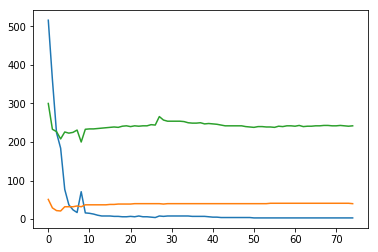

1


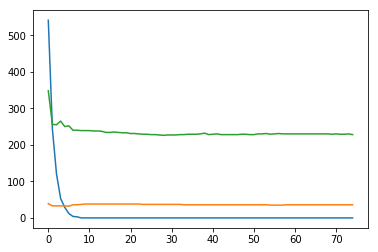

2


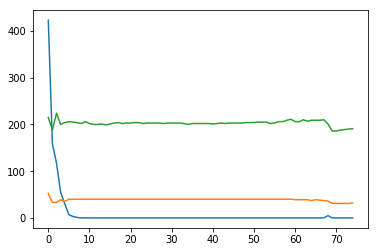

3


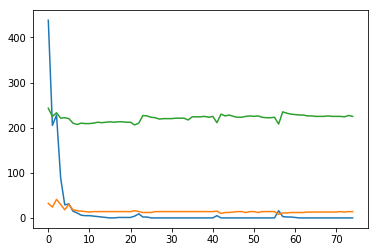

4


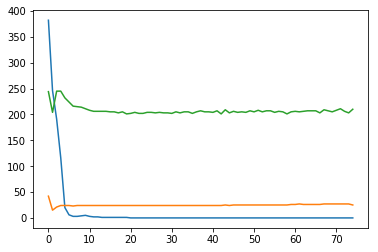

5


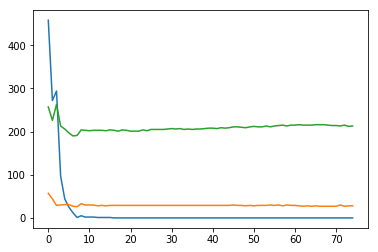

6


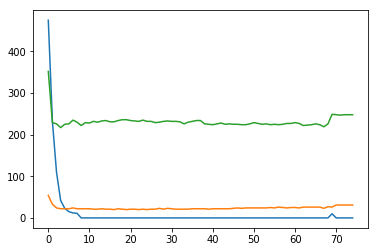

7


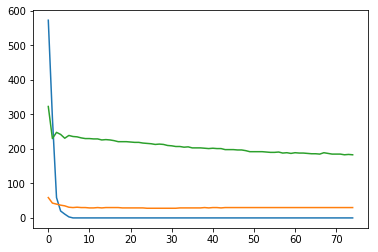

8


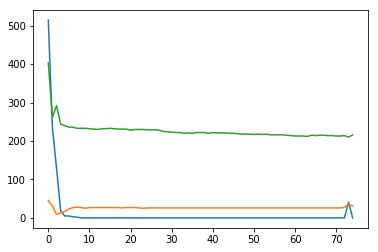

9


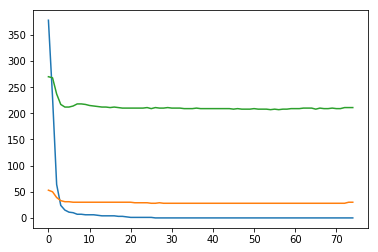

10


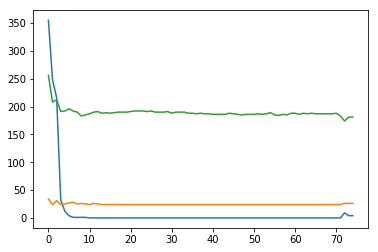

11


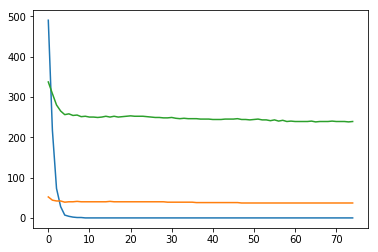

12


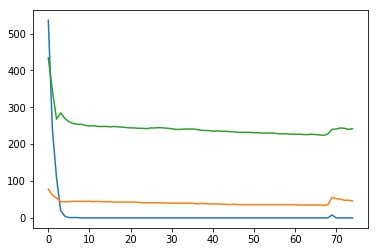

13


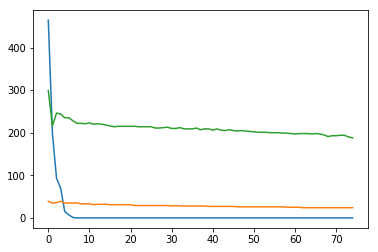

14


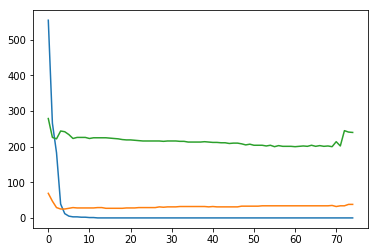

15


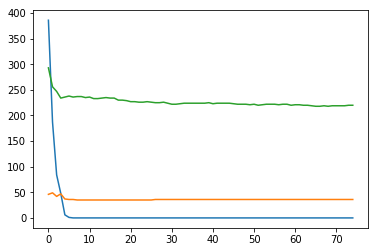

16


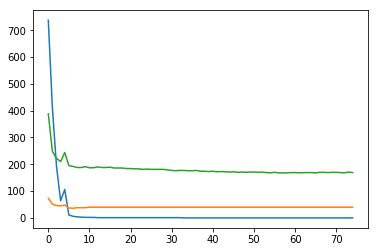

17


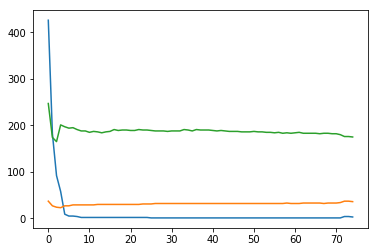

18


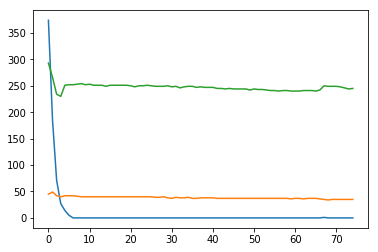

19


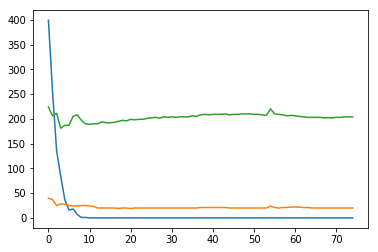

20


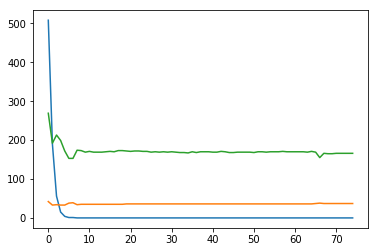

21


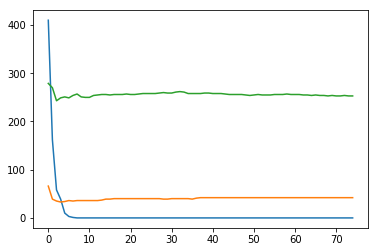

22


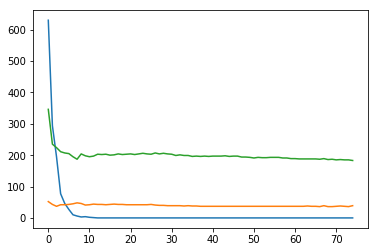

23


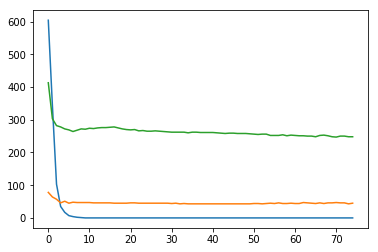

24


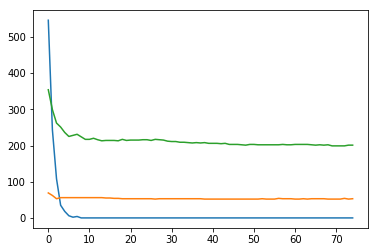

25


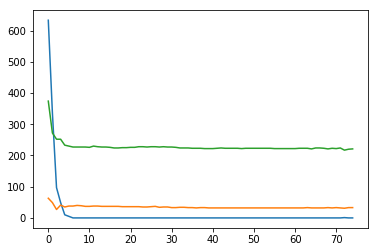

26


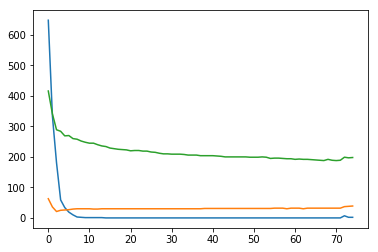

27


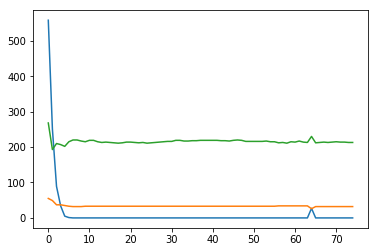

28


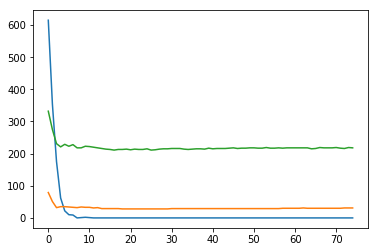

29


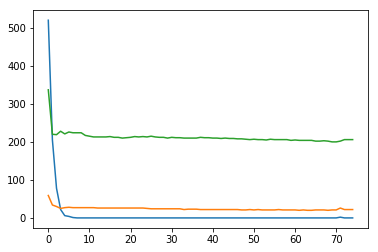

30


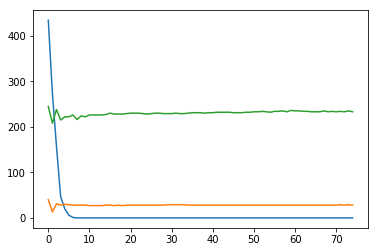

31


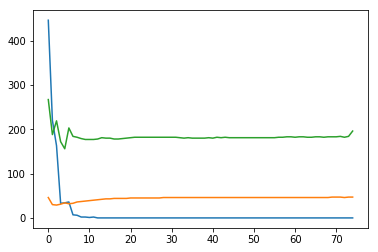

32


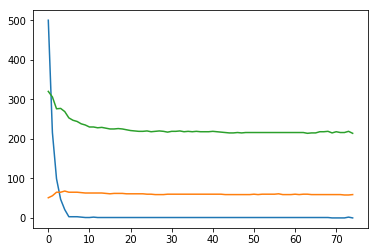

33


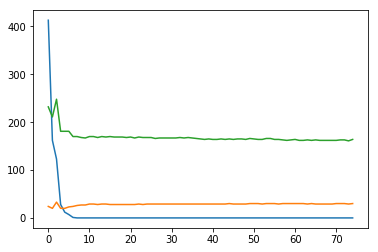

34


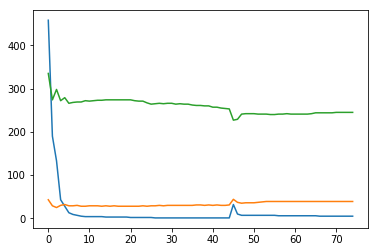

35


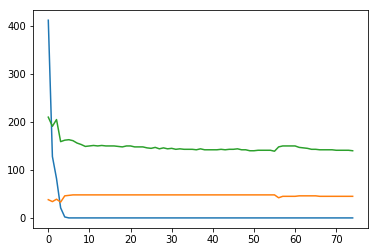

36


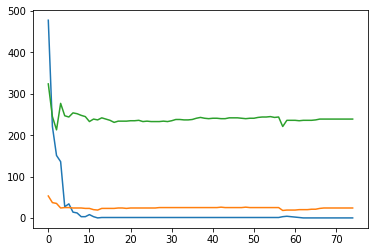

37


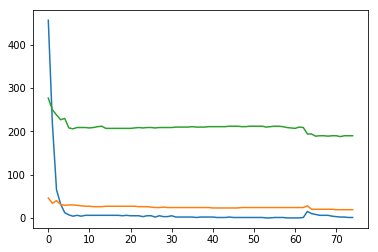

38


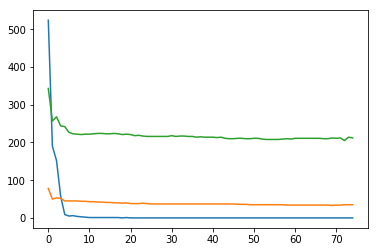

39


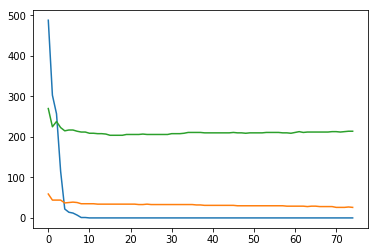

40


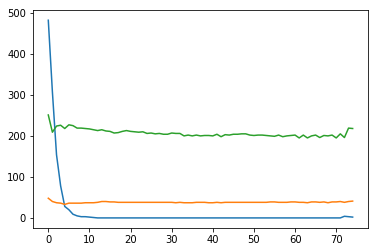

41


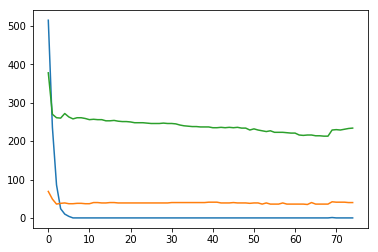

42


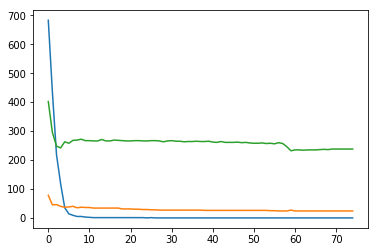

43


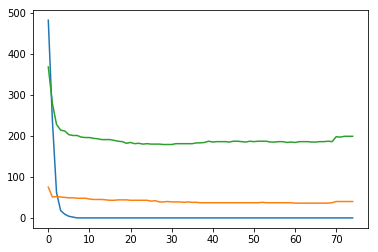

44


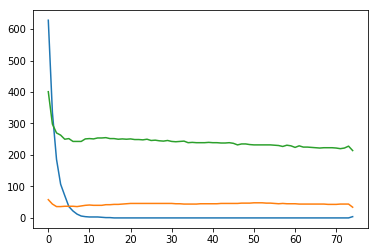

45


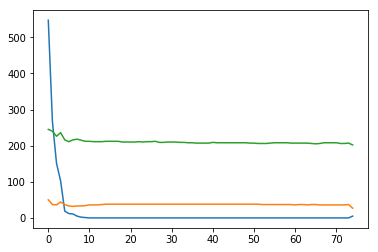

46


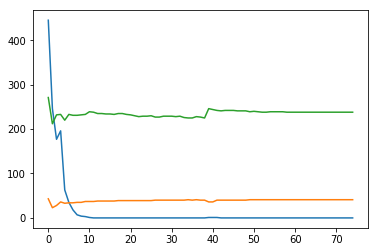

47


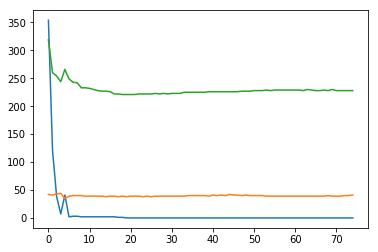

48


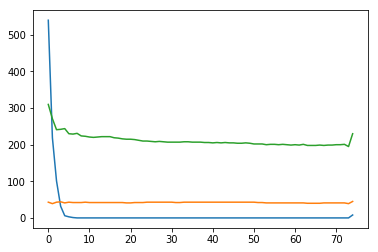

49


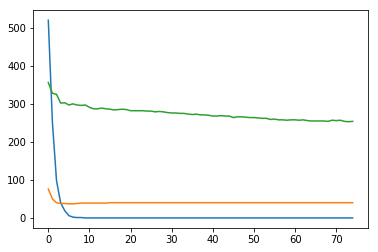

In [7]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


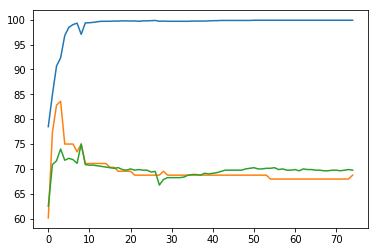

1


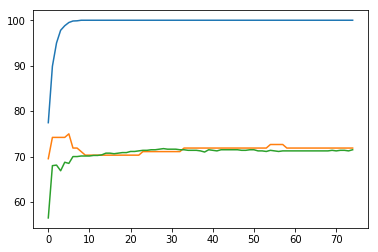

2


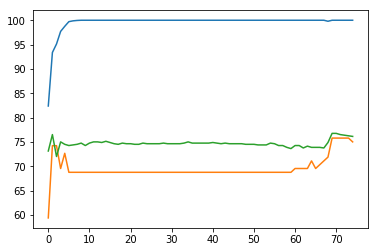

3


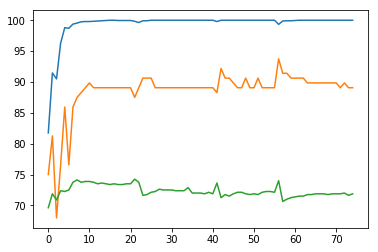

4


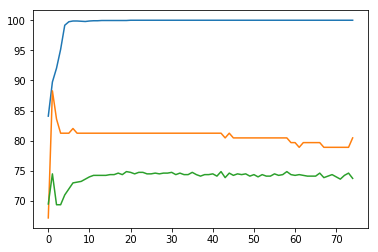

5


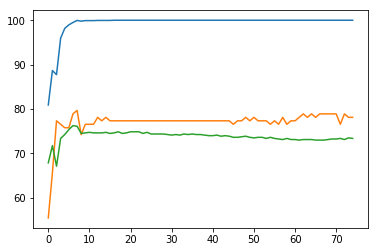

6


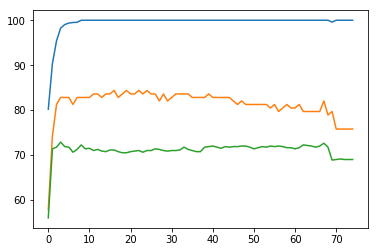

7


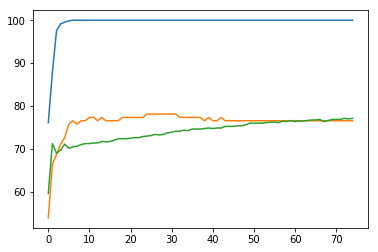

8


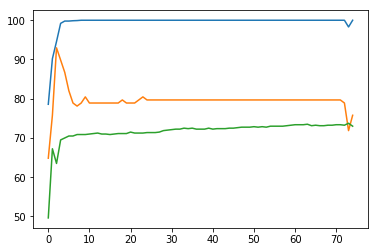

9


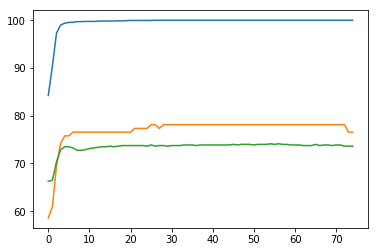

10


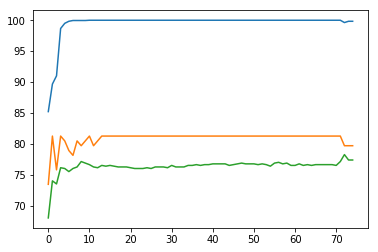

11


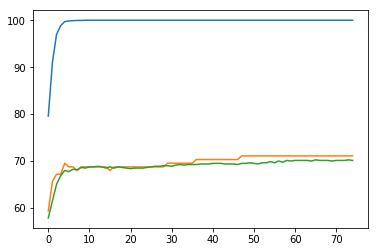

12


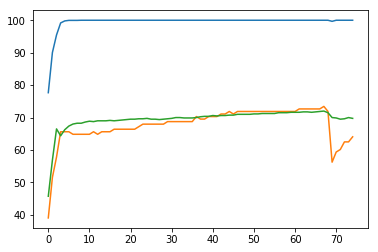

13


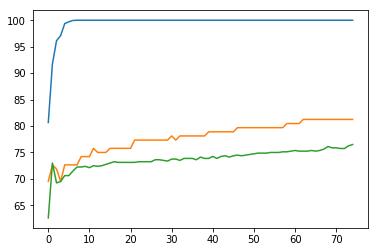

14


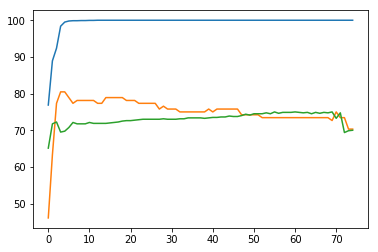

15


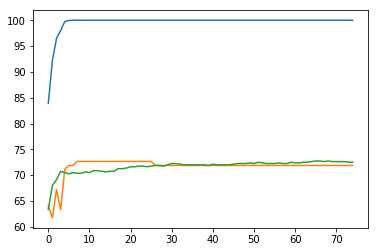

16


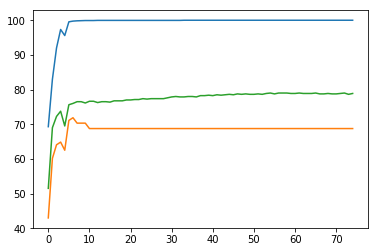

17


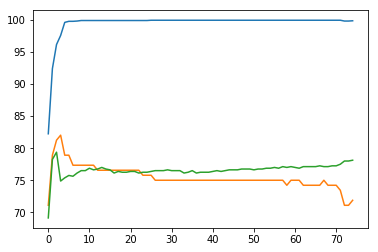

18


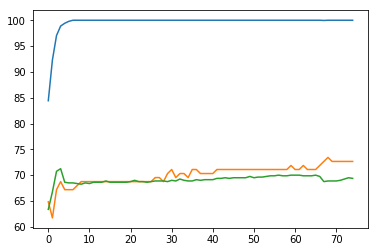

19


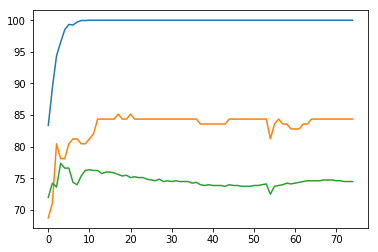

20


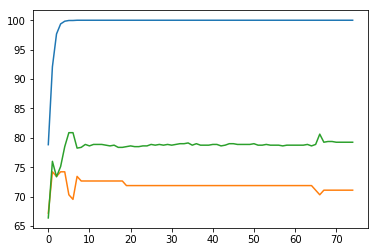

21


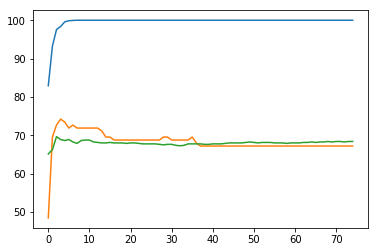

22


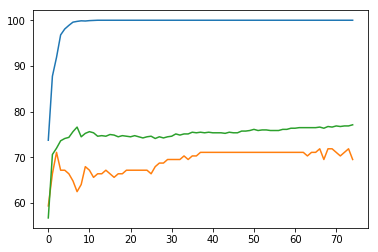

23


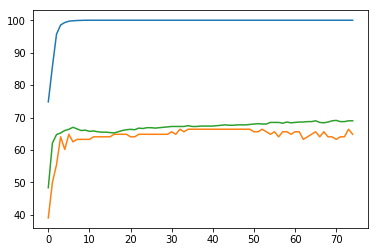

24


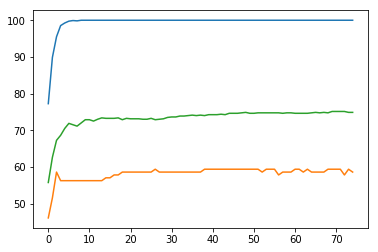

25


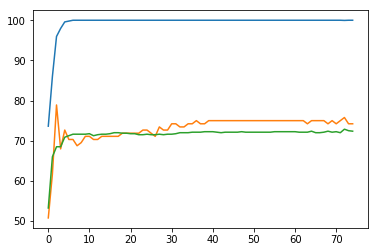

26


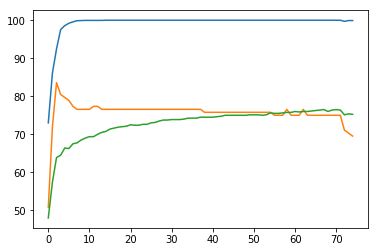

27


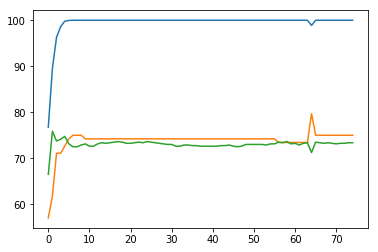

28


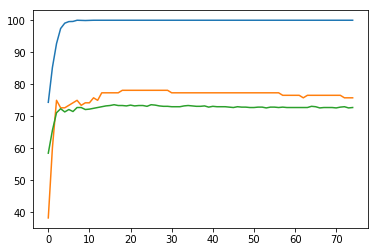

29


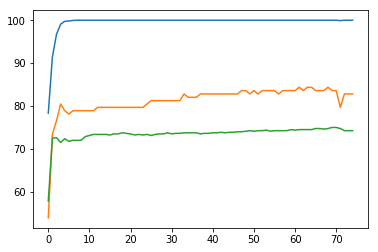

30


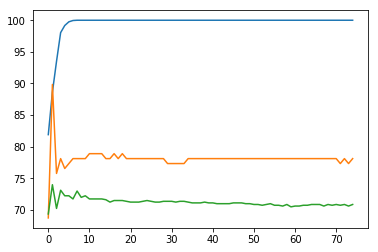

31


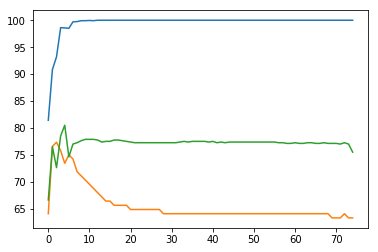

32


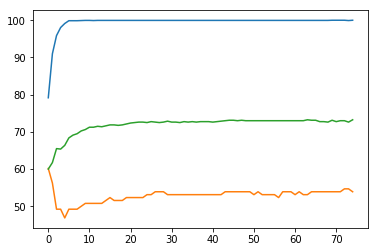

33


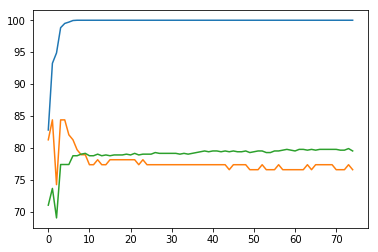

34


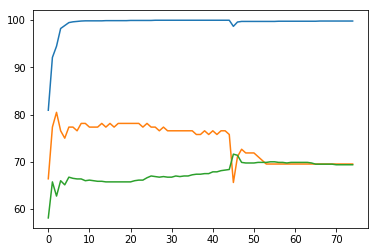

35


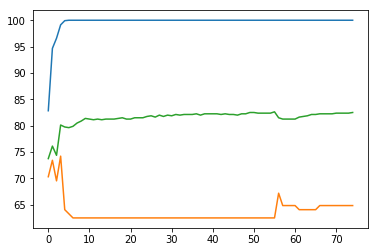

36


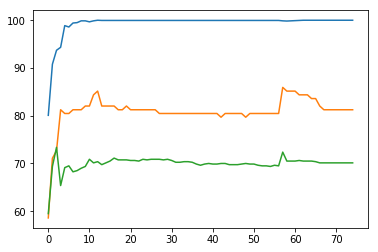

37


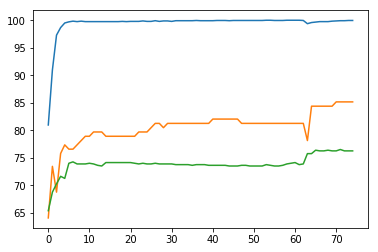

38


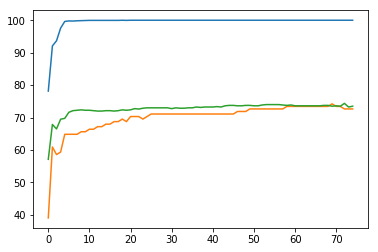

39


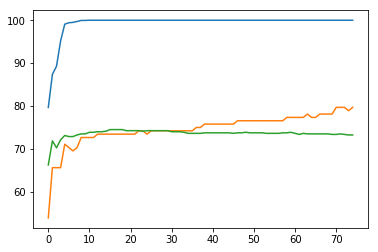

40


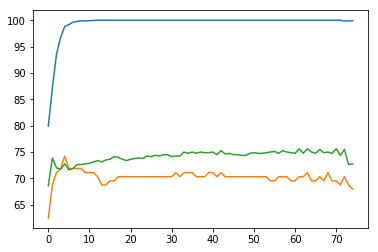

41


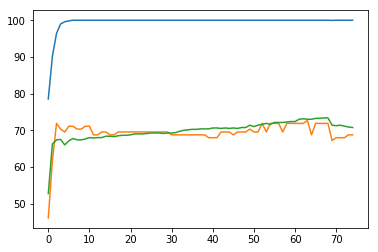

42


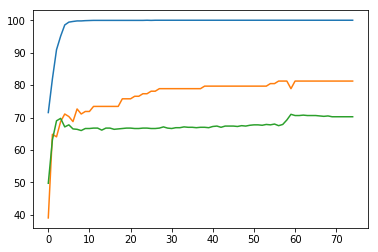

43


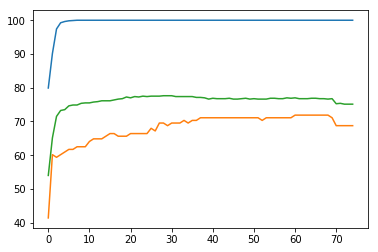

44


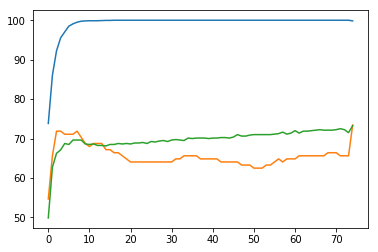

45


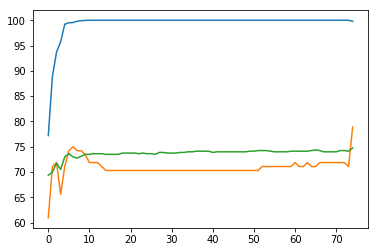

46


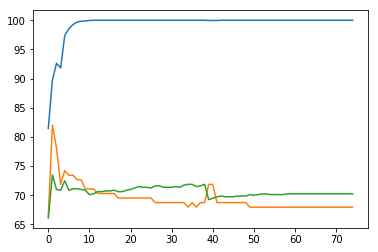

47


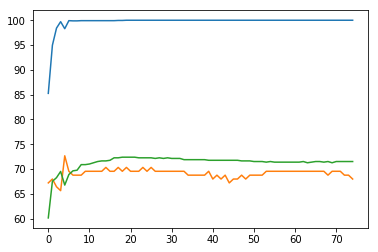

48


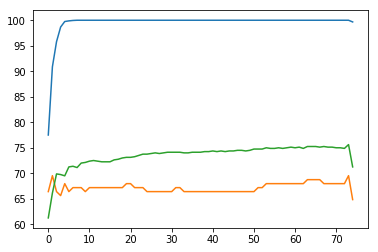

49


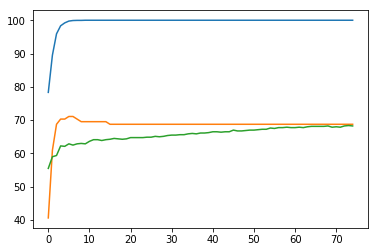

In [8]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(75,)
Training accuracy  100%+-0.0711076632142067
Validation accuracy 72.9%+-6.840485095977783
Testing accuracy 73.3%+-3.2391250133514404


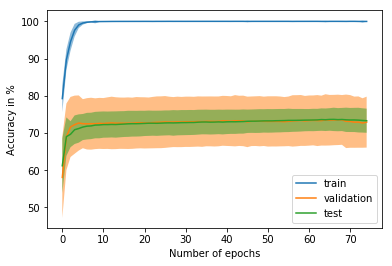

In [10]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(75))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))